<a href="https://colab.research.google.com/github/galileo15640215/kikagaku/blob/master/kikagaku09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ファインチューニング
https://www.kikagaku.ai/tutorial/basic_of_computer_vision/learn/tensorflow_finetuning

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf

In [0]:
# GPU が使用可能であることを確認
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3502025432402976498
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2754622598562316795
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12497775719899351779
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15701463552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3118542059643278242
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [0]:
# データセットの読み込み
train, test = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


In [0]:
# 画像の情報
train[0].shape, test[0].shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [0]:
# ラベルの情報
train[1].shape, test[1].shape

((50000, 1), (10000, 1))

In [0]:
# 学習用データセットとテスト用データセットに対して正規化
x_train = train[0] / 255
x_test = test[0] / 255

In [0]:
# 目標値の切り分け
t_train = train[1]
t_test = test[1]

In [0]:
# 32bit にキャスト
x_train, x_test = x_train.astype('float32'), x_test.astype('float32')
t_train, t_test = t_train.astype('int32'), t_test.astype('int32')

In [0]:
import os, random

def reset_seed(seed=0):
    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [0]:
from tensorflow.keras import models,layers

# シードの固定
reset_seed(0)

# モデルの構築
model = models.Sequential([
    # 特徴量抽出
    layers.Conv2D(filters=3, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPool2D(pool_size=(2, 2)),
    # ベクトル化
    layers.Flatten(),
    # 識別
    layers.Dense(100, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 3)         84        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 3)         0         
_________________________________________________________________
flatten (Flatten)            (None, 675)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               67600     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 68,694
Trainable params: 68,694
Non-trainable params: 0
_________________________________________________________________


In [0]:
# optimizerの設定
optimizer = tf.keras.optimizers.Adam(lr=0.01)

# モデルのコンパイル
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# モデルの学習
batch_size = 4096
epochs = 30

# 学習の実行
history = model.fit(x_train, t_train,
                batch_size=batch_size,
                epochs=epochs, 
                validation_data=(x_test, t_test))

Epoch 1/30
13/13 [==============================] - 1s 54ms/step - loss: 2.1485 - accuracy: 0.2161 - val_loss: 1.9057 - val_accuracy: 0.3297
Epoch 2/30
13/13 [==============================] - 0s 32ms/step - loss: 1.8600 - accuracy: 0.3520 - val_loss: 1.7684 - val_accuracy: 0.3795
Epoch 3/30
13/13 [==============================] - 0s 32ms/step - loss: 1.6807 - accuracy: 0.4035 - val_loss: 1.6393 - val_accuracy: 0.4151
Epoch 4/30
13/13 [==============================] - 0s 32ms/step - loss: 1.5720 - accuracy: 0.4387 - val_loss: 1.5570 - val_accuracy: 0.4404
Epoch 5/30
13/13 [==============================] - 0s 33ms/step - loss: 1.4940 - accuracy: 0.4673 - val_loss: 1.5114 - val_accuracy: 0.4570
Epoch 6/30
13/13 [==============================] - 0s 31ms/step - loss: 1.4457 - accuracy: 0.4863 - val_loss: 1.4688 - val_accuracy: 0.4722
Epoch 7/30
13/13 [==============================] - 0s 31ms/step - loss: 1.4040 - accuracy: 0.5005 - val_loss: 1.4789 - val_accuracy: 0.4733
Epoch 8/30
13

In [0]:
from tensorflow.keras.applications import resnet, VGG16

# 学習済みモデルをインスタンス化
base_model = VGG16(input_shape=(224, 224, 3),
                                      include_top=False, weights='imagenet')

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
# ランダムにデータを取得する
train_choice = np.random.randint(low=0, high=50000, size=10000)
test_choice = np.random.randint(low=0, high=10000, size=5000)

In [0]:
# データの準備
x_train = train[0][train_choice]
x_test = test[0][test_choice]
t_train = train[1][train_choice].astype('int32') 
t_test = test[1][test_choice].astype('int32') 

In [0]:
_train, _test = [], []

# 画像サイズを 224 × 224 にリサイズしてリストに格納
for img in x_train:
    _train.append(cv2.resize(src=img, dsize=(224, 224)))
for img in x_test:    
    _test.append(cv2.resize(src=img, dsize=(224, 224)))

In [0]:
# リストから ndarray に変換し、正規化
x_train = np.array(_train, dtype='float32') / 255.0
x_test = np.array(_test, dtype='float32') / 255.0

In [0]:
x_train.shape, x_test.shape

((10000, 224, 224, 3), (5000, 224, 224, 3))

In [0]:
reset_seed(0)

# モデルの定義
finetuned_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [0]:
optimizer = tf.keras.optimizers.SGD(lr=0.01)

# モデルのコンパイル
finetuned_model.compile(optimizer=optimizer,
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

In [0]:
finetuned_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 14,982,474
Trainable params: 14,982,474
Non-trainable params: 0
_________________________________________________________________


In [0]:
loss, accuracy = finetuned_model.evaluate(x_test, t_test)

157/157 [==============================] - 12s 79ms/step - loss: 2.4449 - accuracy: 0.0912


In [0]:
print(f'loss : {loss}, acuracy : {accuracy}')

loss : 2.444869041442871, acuracy : 0.09120000153779984


In [0]:
# モデルの学習
history = finetuned_model.fit(x_train, t_train, 
                    epochs=10, 
                    batch_size=32,
                    validation_data=(x_test, t_test))

Epoch 1/10
313/313 [==============================] - 81s 258ms/step - loss: 2.0346 - accuracy: 0.2552 - val_loss: 1.6506 - val_accuracy: 0.3446
Epoch 2/10
313/313 [==============================] - 80s 255ms/step - loss: 1.3444 - accuracy: 0.5335 - val_loss: 0.9039 - val_accuracy: 0.7116
Epoch 3/10
313/313 [==============================] - 80s 254ms/step - loss: 0.9592 - accuracy: 0.6722 - val_loss: 0.9368 - val_accuracy: 0.6592
Epoch 4/10
313/313 [==============================] - 80s 254ms/step - loss: 0.6958 - accuracy: 0.7655 - val_loss: 0.6464 - val_accuracy: 0.7768
Epoch 5/10
313/313 [==============================] - 80s 255ms/step - loss: 0.5992 - accuracy: 0.8002 - val_loss: 0.9204 - val_accuracy: 0.6890
Epoch 6/10
313/313 [==============================] - 80s 255ms/step - loss: 0.4338 - accuracy: 0.8510 - val_loss: 0.4350 - val_accuracy: 0.8568
Epoch 7/10
313/313 [==============================] - 80s 255ms/step - loss: 0.3407 - accuracy: 0.8836 - val_loss: 0.5010 - val_ac

In [0]:
results = pd.DataFrame(history.history)
results.tail(3)

,loss,accuracy,val_loss,val_accuracy
7,0.270941,0.9103,0.714467,0.7688
8,0.252486,0.9184,0.367201,0.8804
9,0.245464,0.9180,0.438371,0.8566


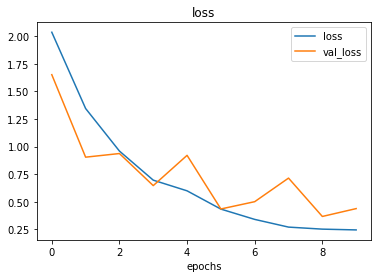

In [0]:
# 損失を可視化
results[['loss', 'val_loss']].plot(title='loss')
plt.xlabel('epochs');

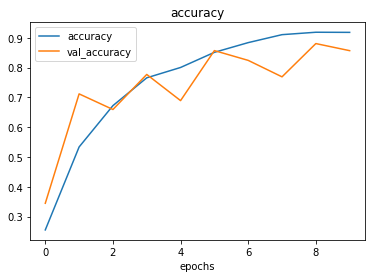

In [0]:
     
# 正解率を可視化
results[['accuracy', 'val_accuracy']].plot(title='accuracy')
plt.xlabel('epochs');